In [320]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.integrate import solve_ivp
from math import dist
import pandas as pd

In [321]:
global NumSpecies,mu,lambdaa,gamma,delta,D,eta,kappa,Ip,NumPatch,immi

In [322]:
def Neighbor(num,x):
    A=np.arange(0,num**2,1)
    B=A.reshape(num,num)
    C=[]
    pin=0
    for i in range(num):
        for j in range(num):
            if B[i,j]==x:
                pin=1
                break
        if pin==1:
            break
    if i-1>=0:
        C=np.append(C,B[i-1,j])
    if i+1<num:
        C=np.append(C,B[i+1,j])
    if j-1>=0:
        C=np.append(C,B[i,j-1])
    if j+1<num:
        C=np.append(C,B[i,j+1])
    return C

In [323]:
def MultiSpecies(t,y):
    yy=y.reshape(NumPatch,NumSpecies*(1+NumSpecies))
    dyydt=np.zeros((NumPatch,NumSpecies*(1+NumSpecies)))
    for qas in range(NumPatch):
        AA=Neighbor(int(np.sqrt(NumPatch)),qas)
        for i in range(NumSpecies):
            ss=1
            sumy_neg=0
            sumy_pos=0
            for j in range(NumSpecies):
                if i!=j:
                    ss=ss*(1+lambdaa[j]*yy[qas,NumSpecies+i*NumSpecies+j]/yy[qas,i])
                if gamma[j,i]<0:
                    sumy_neg=sumy_neg+gamma[j,i]*yy[qas,j]
                if gamma[j,i]>0:
                    sumy_pos=sumy_pos+gamma[j,i]*yy[qas,j]
            MM=0
            for rgn in range(len(AA)):
                MM=(yy[int(AA[rgn]),i]-yy[qas,i])*immi+MM
            dyydt[qas,i]=mu[i]*yy[qas,i]*ss*(1+sumy_neg+delta[i]*sumy_pos/(1+sumy_pos))-D*yy[qas,i]+MM
            for j in range(NumSpecies):
                if j==i:
                    dyydt[qas,NumSpecies+i*NumSpecies+j]=dyydt[qas,i]
                else:
                    ss=1
                    for k in range(NumSpecies):
                        if k!=i and k!=j:
                            ss=ss*(1+lambdaa[k]*yy[qas,NumSpecies+i*NumSpecies+k]/yy[qas,i])
                    donor=0
                    for k in range(NumSpecies):
                        donor=donor+yy[qas,NumSpecies+k*NumSpecies+j]
                    PP=0
                    for rgn in range(len(AA)):
                        PP=(yy[int(AA[rgn]),NumSpecies+i*NumSpecies+j]-yy[qas,NumSpecies+i*NumSpecies+j])*immi+PP
                    dyydt[qas,NumSpecies+i*NumSpecies+j]=mu[i]*yy[qas,NumSpecies+i*NumSpecies+j]*ss*(1+lambdaa[j])*(1+sumy_neg+delta[i]*sumy_pos/(1+sumy_pos))+eta*(yy[qas,i]-yy[qas,NumSpecies+i*NumSpecies+j])*donor-(kappa+D)*yy[qas,NumSpecies+i*NumSpecies+j]+PP
    dydt=dyydt.reshape(-1,NumPatch*NumSpecies*(1+NumSpecies))
    return dydt

In [324]:
NumSpecies=10
NumPatch=100
mu0=0.5
etas=np.arange(0,0.45,0.1)
immi=0.001
neg_fraq=1
pos_fraq=0
delta=0.2*np.ones(NumSpecies)
kappa=0.005
D=0.2
thresh=0.05
nn=10

In [325]:
print(np.zeros((1,2)))

[[0. 0.]]


In [326]:
timespan=np.arange(0,3000.1,.1)
Abun=np.zeros((nn,len(etas),NumPatch,NumSpecies))
for zxc in range(nn):
    lambdaa=-0.4+0.8*np.random.rand(NumSpecies)
    mu=np.multiply(mu0,1+lambdaa)
    gamma=np.zeros((NumSpecies,NumSpecies))
    for i in range(NumSpecies):
        #for j in np.arange(i,NumSpecies,1):
        for j in range(NumSpecies):
            if i==j:
                gamma[i,j]=-1
            else:
                temp=np.random.rand()
                if temp<neg_fraq:
                    gamma[i,j]=-1.05#(1+0.5*np.random.rand())
                    #gamma[j,i]=-(1+0.5*np.random.rand())
                if temp>1-pos_fraq:
                    gamma[i,j]=0.5
                    #gamma[j,i]=0.5

    for i in range(len(etas)):
        eta=etas[i]
        print(zxc*len(etas)+i)
        initial=np.zeros((NumPatch,NumSpecies**2+NumSpecies))
        for sdf in range(NumPatch):
            for j in range(NumSpecies):
                initial[sdf,j]=np.random.rand()#*2/NumSpecies
                initial[sdf,NumSpecies+j*NumSpecies+j]=initial[sdf,j]
        initial=initial.reshape(NumPatch*(NumSpecies**2+NumSpecies))    
        sol=solve_ivp(MultiSpecies,[0,max(timespan)],initial,method='RK45',t_eval=timespan)
        y=np.transpose(sol.y)
        temp=y[-1,:]
        temp=temp.reshape(NumPatch,NumSpecies*(1+NumSpecies))
        for xcv in range(NumPatch):
            Abun[zxc,i,xcv,:]=temp[xcv,range(NumSpecies)]       

0
1
2
3
4
5
6
7
8
9


In [327]:
NumStab=np.zeros((nn,len(etas)))
MetaDiver=np.zeros((nn,len(etas)))
for zxc in range(nn):
    for i in range(len(etas)):
        Index=np.zeros(NumPatch)
        Index[0]=1
        for j in np.arange(1,NumPatch,1):
            tempj=Abun[zxc,i,j,:]
            pin=0
            for k in range(j):
                tempk=Abun[zxc,i,k,:]
                tttt=tempj-tempk
                dis=np.sqrt(sum(np.multiply(tttt,tttt)))
                if dis<thresh:
                    Index[j]=Index[k]
                    pin=1
            if pin==0:
                Index[j]=max(Index)+1

        NumStab[zxc,i]=max(Index)
        AbunTot=np.sum(Abun[zxc,i,:,:],0)
        AbunTot=AbunTot[AbunTot>0]
        AbunTot=np.divide(AbunTot,sum(AbunTot))
        MetaDiver[zxc,i]=np.exp(np.sum(-np.multiply(AbunTot,np.log(AbunTot))))



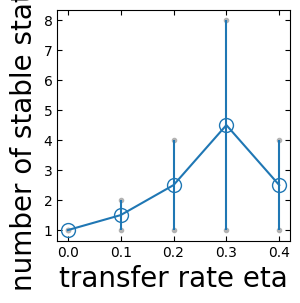

In [328]:
plt.figure(figsize=(3,3))
for i in range(nn):
    plt.plot(etas,NumStab[i,:],'.',color=(0.7,0.7,0.7))
plt.errorbar(etas,np.mean(NumStab,0),yerr=np.std(NumStab,0),marker='o',fillstyle='none',markersize=10)
plt.xlabel('transfer rate eta',fontsize=20)
plt.ylabel('number of stable states',fontsize=20)
plt.tick_params(direction='in',top='true',right='true')
plt.savefig('NumStab_1.pdf')
plt.show()
import pandas as pd
df=pd.DataFrame(NumStab)
df.to_csv("NumStab.csv")

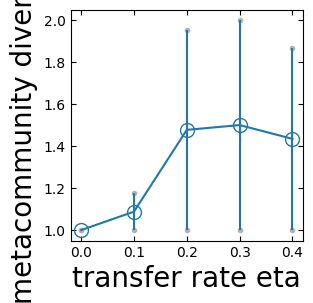

In [329]:
plt.figure(figsize=(3,3))
for i in range(nn):
    plt.plot(etas,MetaDiver[i,:],'.',color=(0.7,0.7,0.7))
plt.errorbar(etas,np.mean(MetaDiver,0),yerr=np.std(MetaDiver,0),marker='o',fillstyle='none',markersize=10)
plt.xlabel('transfer rate eta',fontsize=20)
plt.ylabel('metacommunity diversity',fontsize=20)
plt.tick_params(direction='in',top='true',right='true')
plt.savefig('NumStab_2.pdf')
plt.show()

df=pd.DataFrame(MetaDiver)
df.to_csv("MetaDiver.csv")

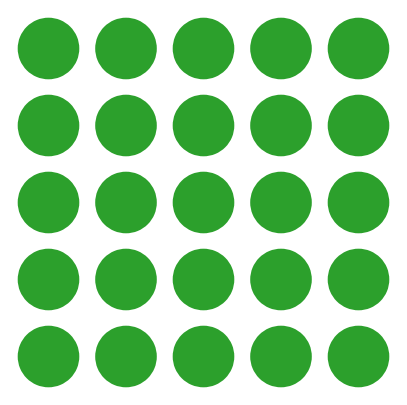

In [334]:
plt.figure(figsize=(5,5))
for i in range(NumPatch):
    plt.subplot(int(np.sqrt(NumPatch)),int(np.sqrt(NumPatch)),i+1)
    plt.pie(np.abs(Abun[1,0,i,:]))
plt.subplots_adjust(wspace=0,hspace=0)
plt.savefig('Meta_Eta0.pdf')
plt.show()

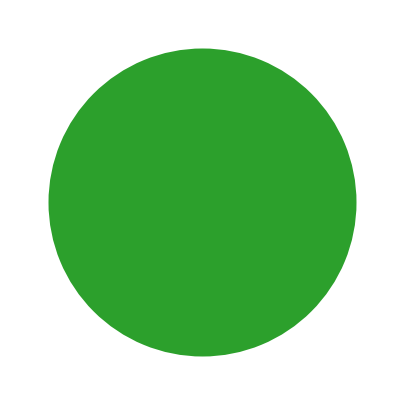

In [335]:
plt.figure(figsize=(5,5))
plt.pie(np.sum(np.abs(Abun[1,0,:,:]),axis=0))
plt.subplots_adjust(wspace=0,hspace=0)
plt.savefig('Meta_Eta0_TotalPie.pdf')
plt.show()

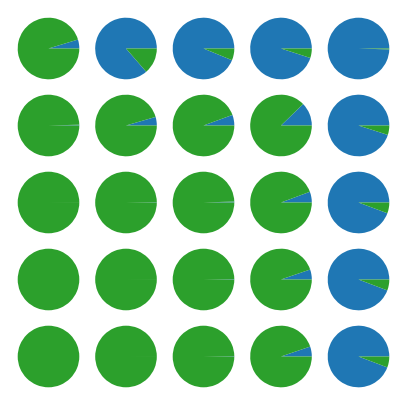

In [336]:
plt.figure(figsize=(5,5))
for i in range(NumPatch):
    plt.subplot(int(np.sqrt(NumPatch)),int(np.sqrt(NumPatch)),i+1)
    plt.pie(np.abs(Abun[1,-1,i,:]))
plt.subplots_adjust(wspace=0,hspace=0)
plt.savefig('Meta_Eta04.pdf')
plt.show()

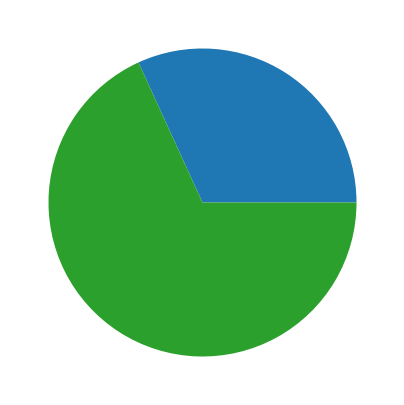

In [337]:
plt.figure(figsize=(5,5))
plt.pie(np.sum(Abun[1,-1,:,:],axis=0))
plt.subplots_adjust(wspace=0,hspace=0)
plt.savefig('Meta_Eta04_TotalPie.pdf')
plt.show()